🚀 Loading dataset and model...
📄 DATA_PATH: c:\Users\User\Desktop\motorbike_project\output_datasets\motorbike_final_dataset_clean.csv
📄 MODEL_PATH: c:\Users\User\Desktop\motorbike_project\output_datasets\best_model_XGBoost.pkl
✅ Dataset shape: (7208, 15)
✅ Model loaded: XGBRegressor
✅ Scaler applied to: ['Tuoi_xe', 'Log_So_Km_da_di', 'Km_moi_nam', 'Tuoi_xe_x_Km']
⚙️ Computing mean price features (brand/dong/segment)...
✅ Mean price columns added & filled
✅ All model features present (after adding mean columns)
🔍 Predicting with 16 features...
📈 R² (Log) = 0.812 | R² (VND) = 0.840
📊 MAE = 6.5 triệu VND | RMSE = 16.4 triệu VND
✅ IsolationForest & OneClassSVM done
🚨 361 xe có giá bất thường (top 5%)


C:\Users\User\AppData\Local\Temp\ipykernel_11364\1574165972.py:226: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Thuong_hieu_code", y="AnomalyScore", palette="Set2", ax=ax3)


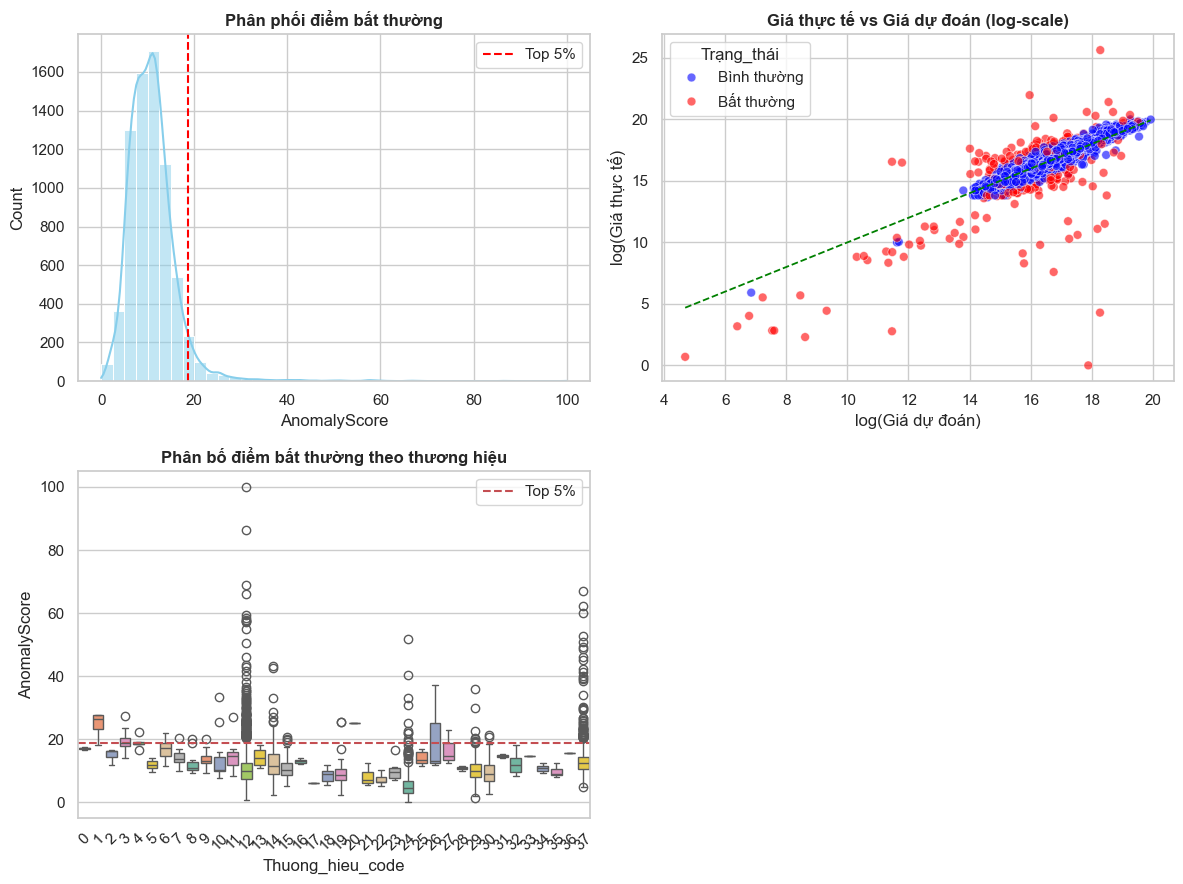

💾 Saved anomaly detection result → c:\Users\User\Desktop\motorbike_project\output_datasets\motorbike_anomaly_detected.csv


In [3]:
import pandas as pd
import numpy as np
import os, joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ LOAD DATA & MODEL
# ============================================================
print("🚀 Loading dataset and model...")

try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

OUTPUT_DIR = os.path.abspath(os.path.join(BASE_DIR, "..", "output_datasets"))
DATA_PATH = os.path.join(OUTPUT_DIR, "motorbike_final_dataset_clean.csv")
MODEL_PATH = os.path.join(OUTPUT_DIR, "best_model_XGBoost.pkl")  
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler_XGBoost.pkl")

print("📄 DATA_PATH:", DATA_PATH)
print("📄 MODEL_PATH:", MODEL_PATH)

df = pd.read_csv(DATA_PATH)
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

print(f"✅ Dataset shape: {df.shape}")
print(f"✅ Model loaded: {type(model).__name__}")

# ============================================================
# 2️⃣ KHỞI TẠO FEATURE NHƯ KHI TRAIN MODEL
# ============================================================
FEATURES = [
    "Tuoi_xe",
    "Log_So_Km_da_di",
    "Km_moi_nam",
    "Tuoi_xe_x_Km",
    "TinhTrang_x_XuatXu",
    "LoaiXe_x_PhanKhuc",
    "Thuong_hieu_code",
    "Dong_xe_code",
    "Loai_xe_code",
    "Tinh_trang_code",
    "Xuat_xu_code",
    "Phan_khuc_dung_tich_code",
    "Vung_mien_code",
    "Brand_mean_price",
    "Dong_mean_price",
    "Segment_mean_price",
]

for f in ["Km_moi_nam", "Tuoi_xe_x_Km"]:
    if f not in df.columns:
        print(f"⚙️ Recomputing {f}...")
        if f == "Km_moi_nam":
            df["Km_moi_nam"] = np.expm1(df["Log_So_Km_da_di"]) / (df["Tuoi_xe"] + 0.1)
        if f == "Tuoi_xe_x_Km":
            df["Tuoi_xe_x_Km"] = df["Tuoi_xe"] * df["Log_So_Km_da_di"]

# --- Scale đúng như lúc train ---
scale_cols = ["Tuoi_xe", "Log_So_Km_da_di", "Km_moi_nam", "Tuoi_xe_x_Km"]

# Nếu file thiếu, tạo tạm các cột numeric cần thiết
for c in scale_cols:
    if c not in df.columns:
        raise KeyError(f"❌ Missing required numeric column: {c}")

df[scale_cols] = scaler.transform(df[scale_cols])
print("✅ Scaler applied to:", scale_cols)


# ============================================================
# 🔧 TẠO 3 CỘT MEAN NẾU THIẾU (đảm bảo đồng bộ model v3/v4)
# ============================================================
if not {"Brand_mean_price", "Dong_mean_price", "Segment_mean_price"}.issubset(df.columns):
    print("⚙️ Computing mean price features (brand/dong/segment)...")

    df["Brand_mean_price"] = df["Thuong_hieu_code"].map(
        df.groupby("Thuong_hieu_code")["Log_Gia"].mean().to_dict()
    )
    df["Dong_mean_price"] = df["Dong_xe_code"].map(
        df.groupby("Dong_xe_code")["Log_Gia"].mean().to_dict()
    )
    df["Segment_mean_price"] = df["Phan_khuc_dung_tich_code"].map(
        df.groupby("Phan_khuc_dung_tich_code")["Log_Gia"].mean().to_dict()
    )

    # Fill missing mean with global mean of Log_Gia
    global_mean = df["Log_Gia"].mean()
    df[["Brand_mean_price", "Dong_mean_price", "Segment_mean_price"]] = df[
        ["Brand_mean_price", "Dong_mean_price", "Segment_mean_price"]
    ].fillna(global_mean)

    print("✅ Mean price columns added & filled")

# ============================================================
# Check lại missing feature cho model
# ============================================================
missing = [c for c in FEATURES if c not in df.columns]
if missing:
    raise KeyError(f"❌ Still missing columns for model inference: {missing}")
else:
    print("✅ All model features present (after adding mean columns)")


# ============================================================
# 3️⃣ DỰ ĐOÁN GIÁ VÀ ĐÁNH GIÁ
# ============================================================
X = df[FEATURES].astype(np.float32)
print(f"🔍 Predicting with {len(FEATURES)} features...")

try:
    y_pred_log = model.predict(X)
except Exception:
    # Nếu model là StackingRegressor (v4)
    y_pred_log = model.predict(X.values)

df["Predicted_Log_Gia"] = y_pred_log
df["Gia_du_doan"] = np.expm1(y_pred_log)
df["Gia_thuc_te"] = np.expm1(df["Log_Gia"])

# --- Đánh giá ---
mask = (df["Gia_thuc_te"] > 0) & (df["Gia_thuc_te"] < 5e8)
df_eval = df[mask]

mae_vnd = mean_absolute_error(df_eval["Gia_thuc_te"], df_eval["Gia_du_doan"])
rmse_vnd = np.sqrt(mean_squared_error(df_eval["Gia_thuc_te"], df_eval["Gia_du_doan"]))
r2_vnd = r2_score(df_eval["Gia_thuc_te"], df_eval["Gia_du_doan"])
r2_log = r2_score(df_eval["Log_Gia"], df_eval["Predicted_Log_Gia"])

print(f"📈 R² (Log) = {r2_log:.3f} | R² (VND) = {r2_vnd:.3f}")
print(f"📊 MAE = {mae_vnd/1e6:.1f} triệu VND | RMSE = {rmse_vnd/1e6:.1f} triệu VND")

# ============================================================
# 4️⃣ TÍNH RESIDUAL & CHUẨN HÓA
# ============================================================
df["Residual"] = df["Log_Gia"] - df["Predicted_Log_Gia"]
df["Residual_z"] = df.groupby("Phan_khuc_dung_tich_code")["Residual"].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-6)
)

# ============================================================
# 5️⃣ RULE-BASED CHECK (P10–P90)
# ============================================================
bounds = (
    df.groupby("Phan_khuc_dung_tich_code")["Gia_thuc_te"]
    .quantile([0.1, 0.9])
    .unstack()
    .rename(columns={0.1: "P10", 0.9: "P90"})
)
df = df.merge(bounds, on="Phan_khuc_dung_tich_code", how="left")
df["Rule_P10P90"] = (df["Gia_thuc_te"] < df["P10"]) | (df["Gia_thuc_te"] > df["P90"])

# ============================================================
# 6️⃣ UNSUPERVISED ANOMALY DETECTION
# ============================================================
unsup_feats = [
    "Tuoi_xe", "Log_So_Km_da_di", "Residual_z",
    "Thuong_hieu_code", "Loai_xe_code", "Tinh_trang_code",
    "Xuat_xu_code", "Phan_khuc_dung_tich_code"
]
X_unsup = df[unsup_feats].fillna(0)
X_scaled = StandardScaler().fit_transform(X_unsup)

iso = IsolationForest(contamination=0.05, random_state=42)
df["IsoScore"] = -iso.fit(X_scaled).decision_function(X_scaled)

svm = OneClassSVM(kernel="rbf", nu=0.05)
df["SvmScore"] = -svm.fit(X_scaled).score_samples(X_scaled)

print("✅ IsolationForest & OneClassSVM done")

# ============================================================
# 7️⃣ COMBINE ANOMALY SCORE
# ============================================================
weights = {"Residual_z": 0.4, "IsoScore": 0.3, "SvmScore": 0.2, "Rule_P10P90": 0.1}
combined = (
    weights["Residual_z"] * np.abs(df["Residual_z"]) +
    weights["IsoScore"] * df["IsoScore"] +
    weights["SvmScore"] * df["SvmScore"] +
    weights["Rule_P10P90"] * df["Rule_P10P90"].astype(int)
)

df["AnomalyScore"] = MinMaxScaler((0, 100)).fit_transform(combined.values.reshape(-1, 1))
threshold = df["AnomalyScore"].quantile(0.95)
df["Anomaly_Flag"] = (df["AnomalyScore"] >= threshold).astype(int)
print(f"🚨 {df['Anomaly_Flag'].sum()} xe có giá bất thường (top 5%)")

# ============================================================
# 8️⃣ VISUALIZATION
# ============================================================
sns.set(style="whitegrid", font="Arial")
df["Trạng_thái"] = df["Anomaly_Flag"].map({1: "Bất thường", 0: "Bình thường"})

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
(ax1, ax2), (ax3, ax4) = axes

sns.histplot(df["AnomalyScore"], bins=40, kde=True, color="skyblue", ax=ax1)
ax1.axvline(threshold, color="red", linestyle="--", label="Top 5%")
ax1.set_title("Phân phối điểm bất thường", fontsize=12, weight="bold")
ax1.legend()

sns.scatterplot(
    data=df,
    x=np.log1p(df["Gia_du_doan"]),
    y=np.log1p(df["Gia_thuc_te"]),
    hue="Trạng_thái",
    palette={"Bất thường": "red", "Bình thường": "blue"},
    alpha=0.6, s=40, ax=ax2
)
ax2.plot(
    [np.log1p(df["Gia_du_doan"]).min(), np.log1p(df["Gia_du_doan"]).max()],
    [np.log1p(df["Gia_du_doan"]).min(), np.log1p(df["Gia_du_doan"]).max()],
    color="green", linestyle="--", linewidth=1.3
)
ax2.set_xlabel("log(Giá dự đoán)")
ax2.set_ylabel("log(Giá thực tế)")
ax2.set_title("Giá thực tế vs Giá dự đoán (log-scale)", fontsize=12, weight="bold")

sns.boxplot(data=df, x="Thuong_hieu_code", y="AnomalyScore", palette="Set2", ax=ax3)
ax3.axhline(threshold, color='r', linestyle='--', label="Top 5%")
ax3.set_title("Phân bố điểm bất thường theo thương hiệu", fontsize=12, weight="bold")
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

ax4.axis('off')
plt.tight_layout()
plt.show()

# ============================================================
# 9️⃣ SAVE RESULT
# ============================================================
out_path = os.path.join(OUTPUT_DIR, "motorbike_anomaly_detected.csv")
df.to_csv(out_path, index=False)
print(f"💾 Saved anomaly detection result → {out_path}")


In [49]:
df["Predicted_Log_Gia"] = model.predict(df_model)
print("Sample compare (Log_Gia vs Predicted_Log_Gia):")
print(df[["Log_Gia", "Predicted_Log_Gia"]].head())
print("Sample compare (Gia_thuc_te vs Gia_du_doan):")
print(df[["Gia_thuc_te", "Gia_du_doan"]].head())



Sample compare (Log_Gia vs Predicted_Log_Gia):
     Log_Gia  Predicted_Log_Gia
0  18.005165          17.978163
1  18.191268          18.148630
2  17.426428          17.373856
3  17.622173          17.619837
4  16.951005          16.924603
Sample compare (Gia_thuc_te vs Gia_du_doan):
   Gia_thuc_te  Gia_du_doan
0   66000000.0   64241680.0
1   79500000.0   76181568.0
2   37000000.0   35105052.0
3   45000000.0   44894992.0
4   23000000.0   22400692.0


In [42]:
print("\n🔍 Sample predictions (log-space):")
print(df[["Log_Gia", "Predicted_Log_Gia"]].head(10))

print("\n🔍 Sample Gia_thuc_te vs Gia_du_doan:")
print(df[["Gia_thuc_te", "Gia_du_doan"]].head(10))





🔍 Sample predictions (log-space):
     Log_Gia  Predicted_Log_Gia
0  18.005165          17.978163
1  18.191268          18.148630
2  17.426428          17.373856
3  17.622173          17.619837
4  16.951005          16.924603
5  15.830414          15.786135
6  16.588099          16.610556
7  15.803385          15.883768
8  15.830414          15.901785
9  17.312018          17.288004

🔍 Sample Gia_thuc_te vs Gia_du_doan:
   Gia_thuc_te  Gia_du_doan
0   66000000.0   64241680.0
1   79500000.0   76181568.0
2   37000000.0   35105052.0
3   45000000.0   44894992.0
4   23000000.0   22400692.0
5    7500000.0    7175152.5
6   16000000.0   16363366.0
7    7300000.0    7911025.5
8    7500000.0    8054848.5
9   33000000.0   32216972.0


In [44]:
a = df["Gia_tren_km"] = np.expm1(df["Log_Gia"]) / (np.expm1(df["Log_So_Km_da_di"]) + 1)
print(a.head())


0    4713.949004
1    2839.184315
2    3083.076410
3     749.987500
4     958.293404
dtype: float64


In [4]:
print("Model expects:", model_features)
print("CSV columns:", df.columns.tolist())


Model expects: ['Tuoi_xe', 'Log_So_Km_da_di', 'Km_moi_nam', 'Gia_tren_km', 'Tuoi_xe_x_Km', 'TinhTrang_x_XuatXu', 'LoaiXe_x_PhanKhuc', 'Thuong_hieu_code', 'Dong_xe_code', 'Loai_xe_code', 'Tinh_trang_code', 'Xuat_xu_code', 'Phan_khuc_dung_tich_code']
CSV columns: ['Gia', 'Log_Gia', 'Tuoi_xe', 'Log_So_Km_da_di', 'Km_moi_nam', 'Gia_tren_km', 'Tuoi_xe_x_Km', 'TinhTrang_x_XuatXu', 'LoaiXe_x_PhanKhuc', 'Vung_mien_code', 'Thuong_hieu', 'Loai_xe', 'Tinh_trang', 'Xuat_xu', 'Phan_khuc_dung_tich', 'Thuong_hieu_code', 'Loai_xe_code', 'Tinh_trang_code', 'Xuat_xu_code', 'Phan_khuc_dung_tich_code']
